# Datatón Anticorrupción 2021 - _Dataket_

Para este trabajo se hizo uso de las [bases de datos ficticias desarrolladas para el **Datatón Anticorrupción 2021**]([https://github.com/PDNMX/dataton2021-datos](https://github.com/PDNMX/dataton2021-datos)). El objetivo de esas bases de datos es permitir el desarrollo de diferentes herramientas para la detección de casos de corrupción en la [**Plataforma Nacional Digital**]([https://www.plataformadigitalnacional.org/especificaciones](https://www.plataformadigitalnacional.org/especificaciones)).

El desarrollo de todo el producto comenzó con la idea de revisar la evolución temporal de la propiedad de cada funcionario que realiza declaraciones. Este análisis se desarrolló bajo la hipótesis de que la variación de las propiedades de una persona corrupta es mayor que la variación de la misma variable para una persona que no delinque.

# Librerías y funciones

## Librería

In [1]:
# Se importan las librerías para el análisis de datos
import pandas as pd
import numpy as np
from scipy import stats

# Librerías para graficar
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go

# Para ML
from sklearn.cluster import KMeans

# Para hacer lectura de archivos json
import json

# Para revisar si los archivos existen en la dirección indicada
from os.path import exists

# Se define la paleta de colores de Dataket 8)
colors = ["#264653", "#2a9d8f", "#e9C46a", "#F4A261", "#E76F51"]

## Funciones

### Lectura de archivos

In [2]:
# Se define una función para leer un json a partir de una direccion
def leer_json(direccion):

    # Se lee el archivo desde su dirección y se guarda en un diccionario
    with open(direccion,'r') as f:
        data = json.loads(f.read())
    return data

### Series de tiempo

In [3]:
# Se crean un par de arreglos a partir de las variables  indicadas
def declaracion_personal(curp, variable_x="anio", variable_y="valor_neto"):
  # Se revisa que el curp exista en las declaraciones
  if len(df.loc[curp]["Declaraciones"])>0:
    # Se construyen las listas
    valores = []
    anios = []
    for i in range(len(df.loc[curp]["Declaraciones"])-1):
      anio = df_declaraciones.iloc[df.loc[curp]["Declaraciones"][i]][variable_x]
      valor = df_declaraciones.iloc[df.loc[curp]["Declaraciones"][i]][variable_y]
      
      anios.append(anio)
      valores.append(valor)
    return anios[:], valores[:]

In [4]:
# Se crea la gráfica de un par de arreglos y se les hace un ajuste lineal
# por mínimos cuadrados y otro por el método de Theil-Sen
def grafica_serie_temporal(anio, valor, cadena):
  # Se revisa que el curp exista en las declaraciones
  if len(anio)==len(valor) and len(anio)>1:
    auxiliar = pd.DataFrame({'Anio': np.array(anio),
                             'Valor': np.array(valor)}).sort_values(by=['Anio']).reset_index()
    anio_minimo = auxiliar["Anio"].min()

    if len(auxiliar[auxiliar["Anio"]==anio_minimo])>1:
      auxiliar = auxiliar.drop(0)

    # Ajuste lineal
    ajuste = np.polyfit(auxiliar["Anio"]-anio_minimo,
                        auxiliar["Valor"], 1) # Mínimos cuadrados
    recta = np.poly1d(ajuste)

    theil = stats.theilslopes(auxiliar["Valor"],
                              auxiliar["Anio"]-anio_minimo, 0.10) # Regresión de Theil-Sen
    

    # Se grafica la serie de tiempo
    fig = px.line(auxiliar, x="Anio", y="Valor",
                    color_discrete_sequence=[colors[1]],
                    title=f"Serie temporal del valor de {cadena}",
                    labels={"Anio": "Año", "Valor": f"Valor de {cadena} (MXN)"})
    
    # Se grafica la recta por mínimos cuadrados
    if (auxiliar["Valor"].diff()!=0).sum()>1:# Se evita que el ajuste no esté definido
      fig.add_trace(go.Line(x=auxiliar["Anio"],
                    y=recta(auxiliar["Anio"]-anio_minimo),
                    showlegend=False,
                    line=dict(color=colors[0], width=3)))
    # Se grafica la recta de Theil-Sen
    fig.add_trace(go.Line(x=auxiliar["Anio"],
                  y=theil[1]+theil[0]*(auxiliar["Anio"]-anio_minimo),
                  showlegend=False,
                  line=dict(color=colors[2], width=3)))

    # Se ajusta el tamaño de la letra
    fig.update_layout(font_size=15)

    # Se guarda el html para poder usarlo en la página web de Dataket 8)
    plotly.offline.plot(fig, filename='/content/drive/MyDrive/Dataton_2021/scatter_'+cadena.replace(" ", "")+'.html')

    # Se muestra la imagen
    fig.show()

### Para realizar muestras para el análisis de las variaciones

In [5]:
# Se realiza una muestra para hacer comparaciones entre las varianzas
def declaracion_muestra(df_sobre_declaraciones, variable_x, variable_y):
  lista = []
  for curp in set(df_sobre_declaraciones["curp"]):

    anio, valor = declaracion_personal(curp, variable_x, variable_y)

    # Se eliminan los datos que repiten año
    auxiliar = pd.DataFrame({'Anio': np.array(anio),
                             'Valor': np.array(valor)}).sort_values(by=['Anio']).reset_index()
    anio_minimo = auxiliar["Anio"].min()
    if len(auxiliar[auxiliar["Anio"]==anio_minimo])>1:
      auxiliar = auxiliar.drop(0).reset_index()

    # Aquí se realiza la revisión de la métrica a usar
    if len(valor)>2:
      suma = 0
      for i in range(len(auxiliar["Valor"])-1):
        if auxiliar["Anio"][i+1]!=auxiliar["Anio"][i]:
          suma += abs((auxiliar["Valor"][i+1]-auxiliar["Valor"][i])/(auxiliar["Anio"][i+1]-auxiliar["Anio"][i]))
      if auxiliar["Valor"].mean()!=0:
        lista.append(abs(suma/auxiliar["Valor"].mean()))

  return np.array(lista[:])

### Agrupación por K-Means y Pairplot

In [6]:
def agrupacion(data_x, n_clusters):
  # Se prepara el algoritmo K-Means y el PCA
  kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0, max_iter=10_000)

  # Se preparan los arrays
  X = data_x.copy()

  # Se ajusta el modelo de k-means minimizando el efecto de
  # los outliers al filtrarlos
  kmeansclus = kmeans.fit(X[X["valor_neto"].between(X["valor_neto"].quantile(.05),
                                                    X["valor_neto"].quantile(.95))])
    
  # Se hacen predicciones de los grupos
  y_kmeans = kmeansclus.predict(X)
  X["grupo"] = y_kmeans

  # Se grafica el pairplot
  sns.pairplot(hue="grupo", data=X)

### El p-value de una variable

In [7]:
# Se calcula el p-value del registro en la distribución de la
# variable dada
def declaracion_pvalue(curp, variable):
  if curp in set(df_curp["curp"]):
    columna = df_curp[variable]
    registro = df_curp[df_curp["curp"]==curp][variable].iloc[0]
    # Se promedia el número de registros de la muestra superiores
    # al estadístico de prueba
    return len(columna[columna<registro])/len(columna), len(columna[columna>registro])/len(columna)

## Lectura de archivos

In [ ]:
# Se define el url donde se encuentra el archivo (en el repositorio de Github)
url_declaraciones = "/content/drive/MyDrive/Dataton_2021/declaraciones.json"

# Se lee el archivo
declaraciones = leer_json(url_declaraciones)

In [ ]:
# Se define el url donde se encuentra el archivo (en el repositorio de Github)
url_contrataciones = "/content/drive/MyDrive/Dataton_2021/SistemaS2.json"

# Se lee el archivo
contratos = leer_json(url_contrataciones)

In [ ]:
# Se define el url donde se encuentra el archivo (en el repositorio de Github)
url_sanciones = "/content/drive/MyDrive/Dataton_2021/Sistema3Servidores.json"

# Se lee el archivo
multas = leer_json(url_sanciones)

### Creación del binario para las consultas

In [ ]:
if not exists('/content/drive/MyDrive/Dataton_2021/relations.pkl'):
    # Obtenemos curps individuales (numero de servidores públicos)

    curps = []

    for multa in multas:
        curps.append(multa['servidorPublicoSancionado']['curp'])

    for contrato in contratos: 
        curps.append(contrato['curp'])

    for declaracion in declaraciones:
        curps.append(declaracion['declaracion']['situacionPatrimonial']['datosGenerales']['curp'])

    curps = set(curps)
    
    print(f"Tenemos registros de {len(curps)} personas.")
    
    # Dataframe para indices por persona.

    aux = []
    for i in range(len(curps)):
        aux.append([[],[],[]])

    df = pd.DataFrame(aux, index = curps, columns = ['Multas', 'Declaraciones', 'Contratos'])

    for curp in curps:
        for i, multa in enumerate(multas):
            if multa['servidorPublicoSancionado']['curp'] == curp:
                df.at[curp, 'Multas'].append(i)

        for i, declaracion in enumerate(declaraciones):
            if declaracion['declaracion']['situacionPatrimonial']['datosGenerales']['curp'] == curp:
                df.at[curp, 'Declaraciones'].append(i)

        for i, contrato in enumerate(contratos): 
            if contrato['curp'] == curp:
                df.at[curp, 'Contratos'].append(i)
                
    df.to_pickle('/content/drive/MyDrive/Dataton_2021/relations.pkl')

else: 
    df = pd.read_pickle('/content/drive/MyDrive/Dataton_2021/relations.pkl')

### Las columnas más importantes de las Declaraciones

In [ ]:
if not exists('/content/drive/MyDrive/Dataton_2021/tabla.pkl'):

  # Se obtienen las columnas más importantes de las Declaraciones para facilitar
  # las consultas
  tabla = []
  for i in range(len(declaraciones)):
    # En esta lista se guardaran los datos relevantes del registro actual
    lista = []

    # id
    lista.append(declaraciones[i]["id"])
    # Año
    lista.append(int(declaraciones[i]["metadata"]["actualizacion"][:4]))
    # CURP
    lista.append(declaraciones[i]["declaracion"]["situacionPatrimonial"]["datosGenerales"]["curp"])

    # Nombre y apellidos
    lista.append(declaraciones[i]["declaracion"]["situacionPatrimonial"]["datosGenerales"]["nombre"])
    lista.append(declaraciones[i]["declaracion"]["situacionPatrimonial"]["datosGenerales"]["primerApellido"])
    lista.append(declaraciones[i]["declaracion"]["situacionPatrimonial"]["datosGenerales"]["segundoApellido"])

    # Nivel de escolaridad
    lista.append(declaraciones[i]["declaracion"]["situacionPatrimonial"]["datosCurricularesDeclarante"]["escolaridad"][-1]["nivel"]["clave"])
    # Nivel de orden de gobierno
    lista.append(declaraciones[i]["declaracion"]["situacionPatrimonial"]["datosEmpleoCargoComision"]["nivelOrdenGobierno"])
    # Nombre del ente público
    lista.append(declaraciones[i]["declaracion"]["situacionPatrimonial"]["datosEmpleoCargoComision"]["nombreEntePublico"])

    # Tiene pareja
    try:
      try:
        if not declaraciones[i]["declaracion"]["situacionPatrimonial"]["datosPareja"]["nunguno"]: # Ojo: dice "nunguno" en lugar de "ninguno"
          lista.append(1) # Sí tiene pareja
        else:
          lista.append(0) # No tiene pareja
      except:
        if not declaraciones[i]["declaracion"]["situacionPatrimonial"]["datosPareja"]["ninguno"]: # Ojo: dice "nunguno" en lugar de "ninguno"
          lista.append(1) # Sí tiene pareja
        else:
          lista.append(0) # No tiene pareja
    except:
      lista.append(0)
    
    # Número de dependientes económicos
    try:
      try:
        if not declaraciones[i]["declaracion"]["situacionPatrimonial"]["datosDependienteEconomico"]["nunguno"]: # Ojo: dice "nunguno" en lugar de "ninguno"
          lista.append(len(declaraciones[i]["declaracion"]["situacionPatrimonial"]["datosDependienteEconomico"]["dependienteEconomico"])) # Sí tiene dependientes
        else:
          lista.append(0) # No tiene dependientes
      except:
        if not declaraciones[i]["declaracion"]["situacionPatrimonial"]["datosDependienteEconomico"]["ninguno"]: # Ojo: dice "nunguno" en lugar de "ninguno"
          lista.append(len(declaraciones[i]["declaracion"]["situacionPatrimonial"]["datosDependienteEconomico"]["dependienteEconomico"])) # Sí tiene dependientes
        else:
          lista.append(0)
    except:
      lista.append(0)

    # Remuneración del cargo público
    try:
      valor = declaraciones[i]["declaracion"]["situacionPatrimonial"]["ingresos"]["remuneracionMensualCargoPublico"]["valor"]
      lista.append(12*valor)
    except:
      try:
        valor = declaraciones[i]["declaracion"]["situacionPatrimonial"]["ingresos"]["remuneracionConclusionCargoPublico"]["valor"]
        lista.append(valor)   
      except:
        try:
          valor = declaraciones[i]["declaracion"]["situacionPatrimonial"]["ingresos"]["remuneracionAnualCargoPublico"]["valor"]
          lista.append(valor)   
        except:
          lista.append(0)

    # Ingreso anual promedio
    try:
      valor = declaraciones[i]["declaracion"]["situacionPatrimonial"]["ingresos"]["totalIngresosMensualesNetos"]["valor"]
      lista.append(12*valor)
    except:
      try:
        valor = declaraciones[i]["declaracion"]["situacionPatrimonial"]["ingresos"]["totalIngresosAnualesNetos"]["valor"]
        lista.append(valor)   
      except:
        try:
          valor = declaraciones[i]["declaracion"]["situacionPatrimonial"]["ingresos"]["ingresoAnualNetoDeclarante"]["valor"]
          lista.append(valor)   
        except:
          valor = declaraciones[i]["declaracion"]["situacionPatrimonial"]["ingresos"]["totalIngresosConclusionNetos"]["valor"]
          lista.append(valor) 
    
    # Valor total de bienes inmuebles.
    try:
      if not declaraciones[i]["declaracion"]["situacionPatrimonial"]["bienesInmuebles"]["ninguno"]:
        propiedades = 0
        for propiedad in declaraciones[i]["declaracion"]["situacionPatrimonial"]["bienesInmuebles"]["bienInmueble"]:
          try:
            propiedades += propiedad["valorAdquisicion"]["valor"]
          except:
            propiedades += propiedad["valorAdquisicion"]
        lista.append(propiedades)
      else:
        lista.append(0)
    except:
      lista.append(0)

    # Valor total de adquisición de vehículos.
    try:
      if not declaraciones[i]["declaracion"]["situacionPatrimonial"]["vehiculos"]["ninguno"]:
        propiedades = 0
        for propiedad in declaraciones[i]["declaracion"]["situacionPatrimonial"]["vehiculos"]["vehiculo"]:
          try:
            propiedades += propiedad["valorAdquisicion"]["valor"]
          except:
            propiedades += propiedad["valorAdquisicion"]
        lista.append(propiedades)
      else:
        lista.append(0)
    except:
      lista.append(0)

    # Valor total de bienes muebles
    try:
      if not declaraciones[i]["declaracion"]["situacionPatrimonial"]["bienesMuebles"]["ninguno"]:
        propiedades = 0
        for propiedad in declaraciones[i]["declaracion"]["situacionPatrimonial"]["bienesMuebles"]["bienMueble"]:
          try:
            propiedades += propiedad["valorAdquisicion"]["valor"]
          except:
            propiedades += propiedad["valorAdquisicion"]
        lista.append(propiedades)
      else:
        lista.append(0)
    except:
      lista.append(0)

    # Valor total de inversiones (saldo diciembre anterior*rendimiento).
    try:
      if not declaraciones[i]["declaracion"]["situacionPatrimonial"]["inversiones"]["ninguno"]:
        propiedades = 0
        for propiedad in declaraciones[i]["declaracion"]["situacionPatrimonial"]["inversiones"]["inversion"]:
          try:
            propiedades += (1+int(propiedad["porcentajeIncrementoDecremento"][:-1])/100)*propiedad["saldoDiciembreAnterior"]["valor"]
          except:
            try:
              propiedades += propiedad["saldoSituacionActual"]["valor"]
            except:
              propiedades += propiedad["saldoFechaConclusion"]["valor"]
        lista.append(propiedades)
      else:
        lista.append(0)
    except:
      lista.append(0)

    # Valor total de deudas (saldo diciembre anterior*rendimiento)
    try:
      if not declaraciones[i]["declaracion"]["situacionPatrimonial"]["adeudos"]["ninguno"]:
        propiedades = 0
        for propiedad in declaraciones[i]["declaracion"]["situacionPatrimonial"]["adeudos"]["adeudo"]:
          try:
            variable = (1+int(propiedad["porcentajeIncrementoDecremento"][:-1])/100)*propiedad["saldoInsolutoDiciembreAnterior"]["valor"]
            propiedades += variable
          except:
            try:
              variable = propiedad["saldoInsolutoSituacionActual"]["valor"]
              propiedades += variable
            except:
              variable = propiedad["saldoInsolutoFechaConclusion"]["valor"]
              propiedades += variable
        
        lista.append(propiedades)
      else:
        lista.append(0)
    except:
      lista.append(0)

    # Valor de propiedades
    lista.append(lista[-3]+lista[-4]+lista[-5])

    # Valor con inversiones
    lista.append(lista[-1]+lista[-3])

    # Valor neto (Valor con inversiones menos deudas)
    lista.append(lista[-1]-lista[-3])

    # Ha tenido sanciones
    if len(df.loc[lista[2]]["Multas"])==0:
      lista.append(0) # No se le ha sancionado
    else:
      lista.append(1) # Se le ha sancionado

    # Se guarda el registro
    tabla.append(lista)

  df_declaraciones = pd.DataFrame(tabla, columns=["id", "anio", "curp", "nombre", "primerApellido",
                              "segundoApellido", "nivelEducativo",
                              "ordenGobierno", "entePublico", "pareja",
                              "numeroDependientes", "remuneracionCargo",
                              "ingresosAnuales", "bienesInmuebles",
                              "vehiculos", "bienesMuebles", "inversiones",
                              "adeudos", "propiedades", "propiedades_inversiones",
                              "valor_neto", "multas"])
  
  df_declaraciones.to_pickle('/content/drive/MyDrive/Dataton_2021/tabla.pkl')

else: 
  df_declaraciones = pd.read_pickle('/content/drive/MyDrive/Dataton_2021/tabla.pkl')

### Datos agrupados por CURP

In [ ]:
if not exists('/content/drive/MyDrive/Dataton_2021/curp.pkl'):

  # Se agrupan las columnas más importantes de las Declaraciones para facilitar
  # las consultas por persona

  tabla = []
  for curp in df.index:
    if curp in set(df_declaraciones["curp"]):
      # Los registros a analizar
      registros = df_declaraciones[df_declaraciones["curp"]==curp].sort_values(by=['anio']).reset_index()
      anio_minimo = registros["anio"].min()
      if len(registros[registros["anio"]==anio_minimo])>1:
        registros = registros.drop(0).reset_index()
      numero = len(registros)

      # curp
      lista = [curp]

      # Nivel educativo promedio
      sublista = []
      for nivel in registros["nivelEducativo"]:
        if nivel=="LIC":
          sublista.append(1)
        elif nivel=="ESP":
          sublista.append(2)
        elif nivel=="MAE":
          sublista.append(3)
        else:
          sublista.append(4)
      lista.append(np.array(sublista).mean())

      # Orden de gobierno promedio
      sublista = []
      for nivel in registros["ordenGobierno"]:
        if nivel=="MUNICIPAL_ALCALDIA":
          sublista.append(1)
        elif nivel=="ESTATAL":
          sublista.append(2)
        else:
          sublista.append(3)
      lista.append(np.array(sublista).mean())

      # Número de pareja promedio
      sublista = registros["pareja"]
      lista.append(np.array(sublista).mean())

      # Número de dependientes promedio
      sublista = registros["numeroDependientes"]
      lista.append(np.array(sublista).mean())

      if numero>=3:
        # Variación de los ingresos anuales
        sublista = registros["ingresosAnuales"].iloc[:]
        lista.append(sublista.std()/sublista.mean())
        subvalor = np.array(sublista).mean()
        # Remuneración del cargo más reciente normalizada al ingreso anual promedio
        lista.append(registros["remuneracionCargo"].iloc[-1]/subvalor)
      else:
        # Variación de los ingresos anuales
        subvalor = registros["ingresosAnuales"].iloc[-1]
        lista.append(0)
        # Remuneración del cargo más reciente normalizada al ingreso anual promedio
        lista.append(registros["remuneracionCargo"].iloc[-1]/subvalor)

      # Variación estandarizada del valor de los bienes inmuebles
      try:
        sublista = registros["bienesInmuebles"].iloc[:]
        if len(sublista)>2:
          lista.append(sublista.std()/sublista.mean())
        else:
          lista.append(0)
      except:
        lista.append(0)

      # Variación estandarizada del valor de los vehículos
      try:
        sublista = registros["vehiculos"].iloc[:]
        if len(sublista)>2:
          lista.append(sublista.std()/sublista.mean())
        else:
          lista.append(0)
      except:
        lista.append(0)

      # Variación estandarizada del valor de los bienes muebles
      try:
        sublista = registros["bienesMuebles"].iloc[:]
        if len(sublista)>2:
          lista.append(sublista.std()/sublista.mean())
        else:
          lista.append(0)
      except:
        lista.append(0)

      # Variación estandarizada del valor de las inversiones
      try:
        sublista = registros["inversiones"].iloc[:]
        if len(sublista)>2:
          lista.append(sublista.std()/sublista.mean())
        else:
          lista.append(0)
      except:
        lista.append(0)
      
      # Variación estandarizada del valor de los adeudos
      try:
        sublista = registros["adeudos"].iloc[:]
        if len(sublista)>2:
          lista.append(sublista.std()/sublista.mean())
        else:
          lista.append(0)
      except:
        lista.append(0)
      
      # Variación estandarizada del valor de las propiedades
      try:
        sublista = registros["propiedades"].iloc[:]
        if len(sublista)>2:
          lista.append(sublista.std()/sublista.mean())
        else:
          lista.append(0)
      except:
        lista.append(0)

      # Variación estandarizada del valor de las propiedades e inversiones
      try:
        sublista = registros["propiedades_inversiones"].iloc[:]
        if len(sublista)>2:
          lista.append(sublista.std()/sublista.mean())
        else:
          lista.append(0)
      except:
        lista.append(0)

      # Variación estandarizada del valor de las propiedades e inversiones menos adeudos
      try:
        sublista = registros["valor_neto"].iloc[:]
        if len(sublista)>2:
          lista.append(sublista.std()/sublista.mean())
        else:
          lista.append(0)
      except:
        lista.append(0)
      
      # Multas
      lista.append(registros["multas"].iloc[0])
      
      # Se guarda el registro
      tabla.append(lista)

  df_curp = pd.DataFrame(tabla, columns=["curp", "nivelEducativo",
                              "ordenGobierno", "pareja",
                              "numeroDependientes", "ingresosAnuales",
                              "remuneracionCargo", "bienesInmuebles",
                              "vehiculos", "bienesMuebles", "inversiones",
                              "adeudos", "propiedades", "propiedades_inversiones",
                              "valor_neto", "multas"])

  df_curp.to_pickle("/content/drive/MyDrive/Dataton_2021/curp.pkl")

else:
  df_curp = pd.read_pickle("/content/drive/MyDrive/Dataton_2021/curp.pkl")

# Análisis

## Series de tiempo

Esta implementación se hizo para dos detalles específicos del dataset de **Declaraciones**: el *Ingreso Anual* y el *Patrimonio Anual*.

Para ambas variables se trazó la evolución temporal a través de los años en los que se registraron sus declaraciones anuales. Sobre esa serie temporal se hizo tanto una [*regresión lineal por mínimos cuadrados*]([https://es.wikipedia.org/wiki/Mínimos_cuadrados](https://es.wikipedia.org/wiki/M%C3%ADnimos_cuadrados)) como una [r*egresión de Theil-Sen*]([https://en.wikipedia.org/wiki/Theil–Sen_estimator](https://en.wikipedia.org/wiki/Theil%E2%80%93Sen_estimator)) para intentar capturar la tendencia real de la evolución de la variable.

In [ ]:
# Se introduce uno de los curps 
curp = "MABG880226MHGRLR03"

# Se crean los arreglos para la evolución de las  propiedades y se grafican
auxiliar_anio, auxiliar_valor = declaracion_personal(curp, "anio", "propiedades")
grafica_serie_temporal(auxiliar_anio[:], auxiliar_valor[:], "propiedades")

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [ ]:
# Se crean los arreglos para la evolución de los ingresos anuales y se grafican
auxiliar_anio, auxiliar_valor = declaracion_personal(curp, "anio", "ingresosAnuales")
grafica_serie_temporal(auxiliar_anio[:], auxiliar_valor[:], "ingresos anuales")

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




## Análisis de las variaciones

El paso tomado luego de estimar las tendencias de las series temporales anteriores, fue utilizar la información de las dispersiones respecto a las pendientes para determinar si había una diferencia estadística entre las variaciones de las personas con antecedentes de sanciones y las personas sin antecedentes (la información sobre  los antecedentes, se obtuvo a partir del dataset de **Sanciones**). A partir del promedio y varianza de ambas muestras, se concluyó que no hay evidencia estadísticamente significativa para concluir que los antecedentes de las personas estudiadas influya en la varianza de sus series temporales.

In [ ]:
# Se crea una base de datos para gente con antecedentes de sanciones
# y otra sin antecedentes
df_sancion = df_declaraciones[df_declaraciones["multas"]==1]
df_sin_sancion = df_declaraciones[df_declaraciones["multas"]==0]

### Patrimonio

In [ ]:
# Se construyen ambas muestras
declaraciones_buenos = declaracion_muestra(df_sin_sancion, "anio", "propiedades")
declaraciones_malos = declaracion_muestra(df_sancion, "anio", "propiedades")

In [ ]:
# Los parámetros muestrales de la gente con antecedentes
declaraciones_malos.mean(), declaraciones_malos.std()

(0.19247778278978947, 0.3070702676341607)

In [ ]:
# Los parámetros muestrales de la gente sin antecedentes
declaraciones_buenos.mean(), declaraciones_buenos.std()

(0.20565167965061423, 0.33444689765988694)

### Ingresos Anuales

In [ ]:
# Se construyen ambas muestras
declaraciones_buenos = declaracion_muestra(df_sin_sancion, "anio", "ingresosAnuales")
declaraciones_malos = declaracion_muestra(df_sancion, "anio", "ingresosAnuales")

In [ ]:
# Los parámetros muestrales de la gente con antecedentes
declaraciones_malos.mean(), declaraciones_malos.std()

(0.985960277936071, 0.27341535029443503)

In [ ]:
# Los parámetros muestrales de la gente sin antecedentes
declaraciones_buenos.mean(), declaraciones_buenos.std()

(0.9826278028851956, 0.263123944784741)

### Notas

Note que todas las pruebas reflejan sólo el comportamiento de los datasets utilizados. Las inferencias hechas hasta ahora y en el resto documento no pueden extrapolarse a otros contextos. hay que recordar que los datos usados son sintéticos.

Es justo mencionar que, al comparar el número promedio de contratos recibidos para personas con sanciones y el de personas sin sanciones, se concluyó que casi todas las personas con contratos contaban con 2 contratos, salvo una que tenía 3. Eso indica que el número de contrataciones recibidas tampoco cambia para personas con o sin sanciones. Esa información se obtuvo a partir del dataset de **Contrataciones**.

## Machine Learning

Como las sanciones resultaron no ser relevantes para el estudio, no se contaban con etiquetas para entrenar un algoritmo de [Machine Learning](https://blog.bismart.com/diferencias-machine-learning-supervisado-no-supervisado) de aprendizaje supervisado que predijera si una persona podía ser acreedora a una sanción o no. Por lo mismo, se estudió la posibilidad de encontrar patrones en los datos de las declaraciones por medio de un algoritmo de aprendizaje no supervisado.

### Kmeans

Para la exploración, se usó el algoritmo [*K-Means*]([https://es.wikipedia.org/wiki/K-medias](https://es.wikipedia.org/wiki/K-medias)) para dos centroides (para intentar encontrar una clasificación de sujetos corruptos y no corruptos). Para este algoritmo se usó una base de datos con variables históricas agrupadas por persona: como su nivel de escolaridad promedio a lo largo de las declaraciones o la desviación estándar de los bienes inmuebles dividida entre su promedio.

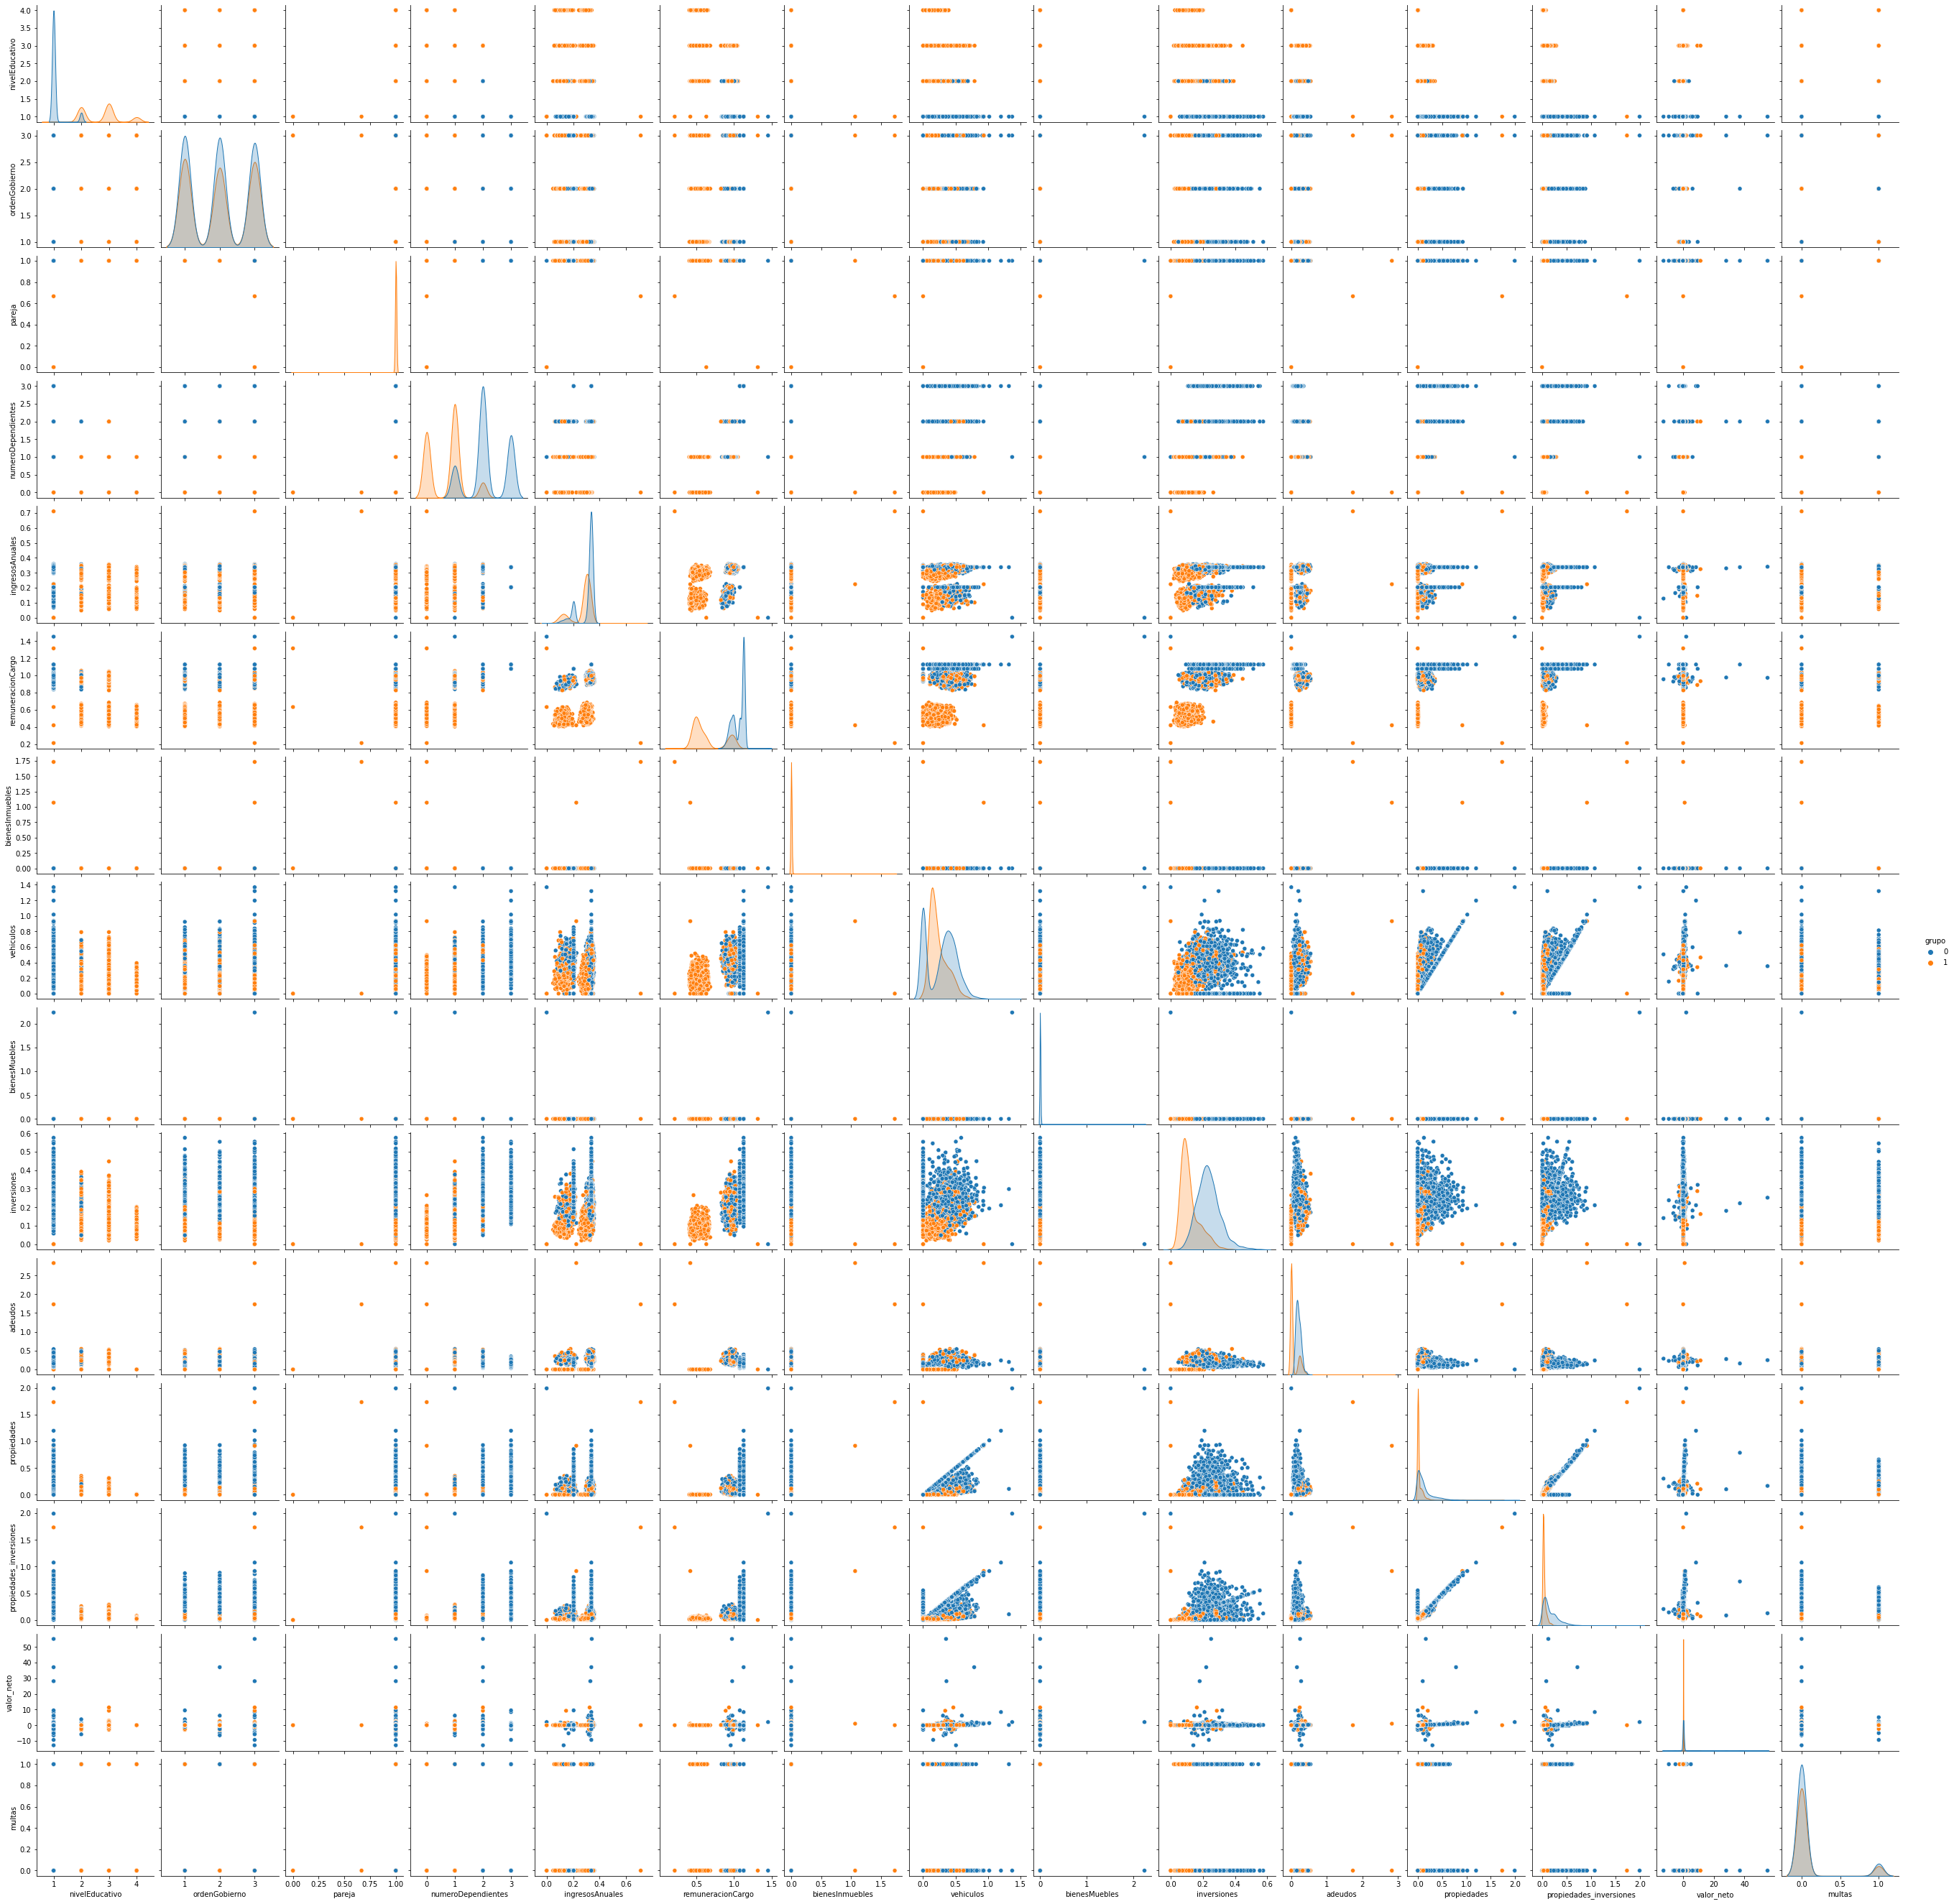

In [ ]:
# Se hace un pairplot de la agrupación recomendada por k-means
agrupacion(df_curp.drop("curp", axis=1), 2)

El algoritmo permitió ver algunas agrupaciones interesantes. En el siguiente [**pairplot**]([https://medium.com/analytics-vidhya/pairplot-visualization-16325cd725e6#:~:text=Pair plot is used to,separation in our data-set](https://medium.com/analytics-vidhya/pairplot-visualization-16325cd725e6#:~:text=Pair%20plot%20is%20used%20to,separation%20in%20our%20data-set).) se  puede observar cómo se ve la agrupación propuesta por el algoritmo en las distintas variables usadas en el modelo (si bien es un gráfico que puede parecer intimidante, se recomienda agrandar la imagen y revisar el nombre de cada fila y columna). Puede notarse que el algoritmo produce una separación entre las personas con Licenciatura y algunas con Especialidad (*color azul*) y las personas con Maestría y Doctorado (*color naranja*). Esta agrupación permite identificar que hay personas del grupo azul que tienen mucha variación en algunos de sus valores patrimoniales, a pesar de que la distribución de la variación de los ingresos es similar en ambos grupos. De hecho, las remuneraciones de los cargos que desempeñan (estandarizada a partir del promedio de los ingresos anuales) para el grupo azul es mayor que la variación en el grupo naranja: eso implica que, estadísticamente, el nivel del puesto no está directamente relacionado con el nivel de estudios, sino al contrario. Todo lo mencionado se puede corroborar al ver los gráficos de densidad en la diagonal principal del pairplot.

## Distribuciones

Las observaciones del pairplot anterior llevaron a la pregunta de cómo se vería la gráfica anterior pero sin clasificaciones de por medio. En la siguiente figura se muestra el pairplot sin separación en grupos. Las variables relacionadas con bienes, inversiones, adeudos e ingresos son las que muestran con mayor claridad la existencia de outliers, es decir, individuos con mucha variabilidad en esas variables históricas.

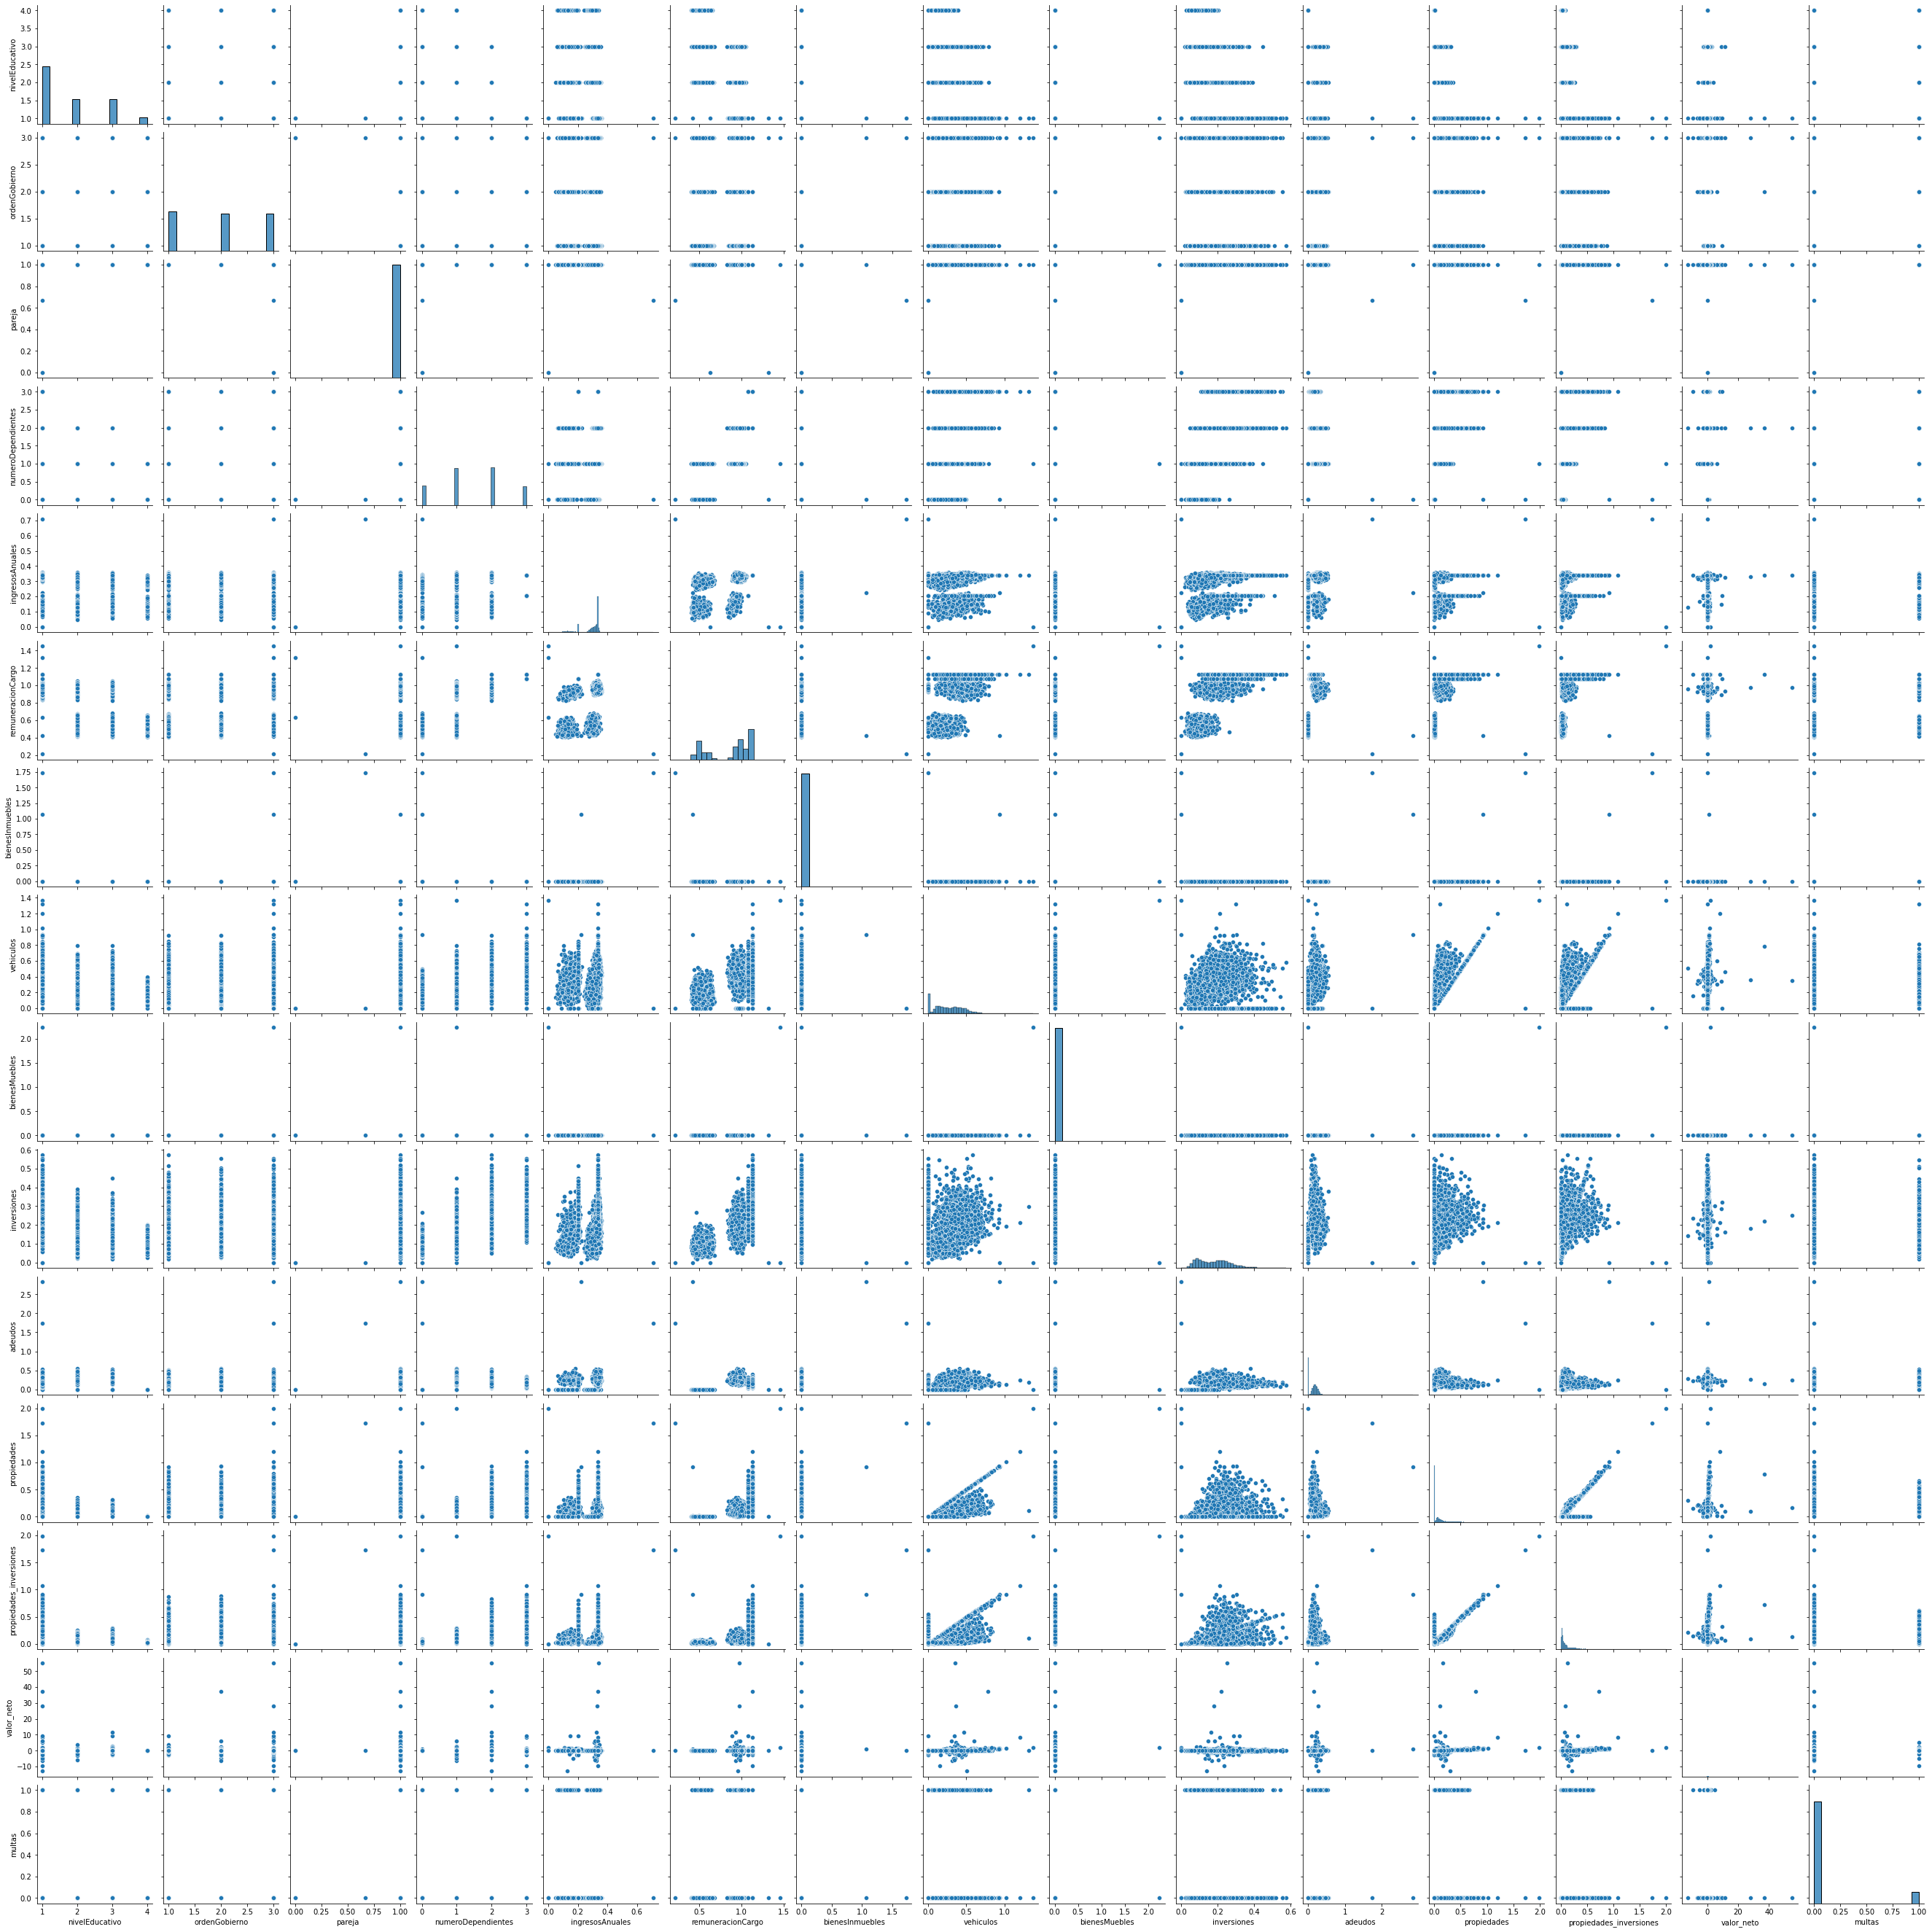

In [ ]:
# Se hace un pairplot de las variables agrupadas
sns.pairplot(df_curp.drop("curp", axis=1))

### Distribuciones de las variables

A partir de la información obtenida de las distribuciones de la dispersión de las variables de patrimonio e ingresos, se pueden identificar casos sospechosos por corrupción: esto al ser individuos con *demasiada* variabilidad en su patrimonio. Es posible determinar qué tan sospechoso es un individuo a partir de su posición en la distribución de una variable.

In [ ]:
if not exists("/content/drive/MyDrive/Dataton_2021/interesantes.pkl"):
  # Se crea la lista de outliers al nivel de confianza de 99.9%
  lista = []
  for curp in set(df_curp["curp"]):
    interesante = False
    columnas = []

    registro = df_declaraciones[df_declaraciones["curp"]==curp]
    # Se revisan las columnas con datos patrimoniales y de ingresos
    for columna in list(df_curp.columns)[5:15]:
      if declaracion_pvalue(curp, columna)[0]>=0.9 and declaracion_pvalue(curp, columna)[1]<=0.001:
        subregistro = registro[columna]
        no_es_constante = (subregistro.diff()!=0).sum()>2
        if columna!="remuneracionCargo" and no_es_constante:
          interesante = True
          columnas.append(columna)
        elif columna=="remuneracionCargo":
          interesante = True
          columnas.append(columna)

    if interesante:
      lista.append([curp, len(columnas), columnas])

  df_interesantes = pd.DataFrame(lista,
                                columns=["curp", "numero",
                                          "columnas_interesantes"]).sort_values(by=["numero"],
                                                                                ascending=False).reset_index(drop=True)
  df_interesantes.to_pickle("/content/drive/MyDrive/Dataton_2021/interesantes.pkl")

else:
  df_interesantes = pd.read_pickle("/content/drive/MyDrive/Dataton_2021/interesantes.pkl")

In [ ]:
df_interesantes

,curp,numero,columnas_interesantes
0,MABG880226MHGRLR03,3,"[remuneracionCargo, propiedades, propiedades_i..."
1,URKR730105MAGRRC07,3,"[vehiculos, propiedades, propiedades_inversiones]"
2,SAZR870019MAGMBB03,3,"[vehiculos, propiedades, propiedades_inversiones]"
3,MEVS800022HSNZLL06,3,"[vehiculos, propiedades, propiedades_inversiones]"
4,FICM790609MDFLRR03,2,"[vehiculos, propiedades_inversiones]"
5,JICG760520MSNMRR07,1,[inversiones]
6,ALLV710808MAGBCC02,1,[valor_neto]
7,CEDJ850827HVZRLN01,1,[adeudos]
8,ROCA900530MYNDLL04,1,[remuneracionCargo]
9,MOUI700607HSNNBN02,1,[valor_neto]


La propuesta de este producto es la posibilidad de ingresar un identificador personal (como puede ser el CURP) al sistema de consulta y que éste muestre el nivel de riesgo de corrupción del funcionario en cuestión. El sistema también indica las variables por las cuales es sospechoso. En base a esas indicaciones, se pueden realizar análisis más profundos y personalizados. Esos análisis personalizados se pueden encaminar al mostrar las series de tiempo apropiadas de acuerdo a las variables donde se sospecha. De esta manera, el sistema provee de  las herramientas apropiadas para tener el contexto inicial para emprender una investigación para un sospechoso de corrupción.

En uno de los subproductos desarrollados se pueden realizar listas de sospechosos y asignarles una prioridad en base a la cantidad de variables en las que se sospecha. Como trabajo al futuro, se pueden usar esas listas para buscar patrones que permitan el entrenamiento supervisado de algoritmos de Machine Learning, así como la identificaciones de variables más específicas. También se propone la construcción de un mapeo que abarque todas las organizaciones públicas de todos los niveles con todos sus organigramas internos: con ese objeto y las herramientas desarrolladas, se podría realizar un *grafo de la corrupción*, permitiendo identificar jefes corruptos en función de la cantidad de subordinados corruptos a su cargo.